## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at depths chosen by the SED-SVD technique and others in order to compare them. Finally, the predicted data from the optimal layer is selected.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from __future__ import division
from coord import GGS
from equiv_layer import EqLayer
from map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

### Importing observational points (planimetric only)

In [3]:
# IMPORTING BDG FILE
path = '../data/BDG/'
uf = 'RJ'
name_bdg = '_file.txt'
lon, lat, alt, grav_bdg = np.loadtxt('{p}{u}{nb}'.format(p=path,u=uf,nb=name_bdg), \
skiprows=1, unpack=True)

# IMPORTING EIGEN FILE
name_eigen = '.dat'
grav_eigen = np.loadtxt('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen),skiprows=32, usecols=(4,),unpack=True)

# Obtaining short wavelength signals
disturb = grav_bdg - grav_eigen
print disturb[0], disturb.size, lon.size, lat.size, alt.size#, h_eigen.size

-12.8409953 2057 2057 2057 2057


In [4]:
print lon.min(), lon.max()
print lat.min(), lat.max()

-44.8278 -40.9786
-23.344 -20.7727


In [5]:
tobedel = np.where(np.abs(disturb)>110.)[0]
# print tobedel.size, tobedel, disturb[tobedel], alt[tobedel]

In [6]:
# disturb = np.delete(disturb, tobedel)
# lon = np.delete(lon, tobedel)
# lat = np.delete(lat, tobedel)
# alt = np.delete(alt, tobedel)
print disturb.size, lon.size, lat.size, alt.size

2057 2057 2057 2057


In [7]:
# # CHANGE ALTITUDE UNITS ON MAP
# point_map(lon, lat, alt, alt, uf, cmap='terrain', edges=(-45.5,-40.9,-23.6,-20.4), \
#           center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
#           residual=True, fig_size=(9.,10.))#, save=name)

In [8]:
# point_map(lon, lat, alt, disturb, uf, edges=(-45.5,-40.9,-23.6,-20.4), \
#           center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
#           lim_val=(True,30), fig_size=(9.,10.))#, save=name)

### Calculating rotation matrices and Cartesian coordinates

In [9]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(lon, lat, alt)
R = np.array(rotation_matrix(lon, lat))

## Estimativa das camadas locais

In [10]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5

In [11]:
latc = []
lonc = []

## Iteração 1 - A0 L2 norm

In [12]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print hcl, type(indl), #indl

3000.0 <type 'numpy.ndarray'>


In [13]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [14]:
Rcl = R[:, indl]

In [15]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(lon, lat, np.zeros_like(lon)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print Acc_l.shape

(2057, 2057)


In [16]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [17]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

2057


In [18]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [19]:
indexing = np.where(rcl==np.max(rcl))[0]
index = np.where(disturb==np.max(disturb))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], disturb[indexing], np.dot(Acc_l, p_L2)[indexing]
print 'MAX FOR DISTURB'
print rcl[index], disturb[index], np.dot(Acc_l, p_L2)[index]

MAX FOR RESIDUALS
[ 0.24724154] [ 2.7427022] [ 2.49546066]
MAX FOR DISTURB
[  1.38517038e-08] [ 47.0498974] [ 47.04989739]


In [20]:
print np.std(rcl)

0.00797001239493


In [21]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

0.24724153904111157

In [22]:
print rabs_max, rabs_max_l

[] 0.247241539041


In [23]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [24]:
latc.append(latcl)
lonc.append(loncl)

In [25]:
rabs_max.append(rabs_max_l)

In [26]:
rc = rcl[:] #r1

In [27]:
print np.max(np.abs(rc))

0.247241539041


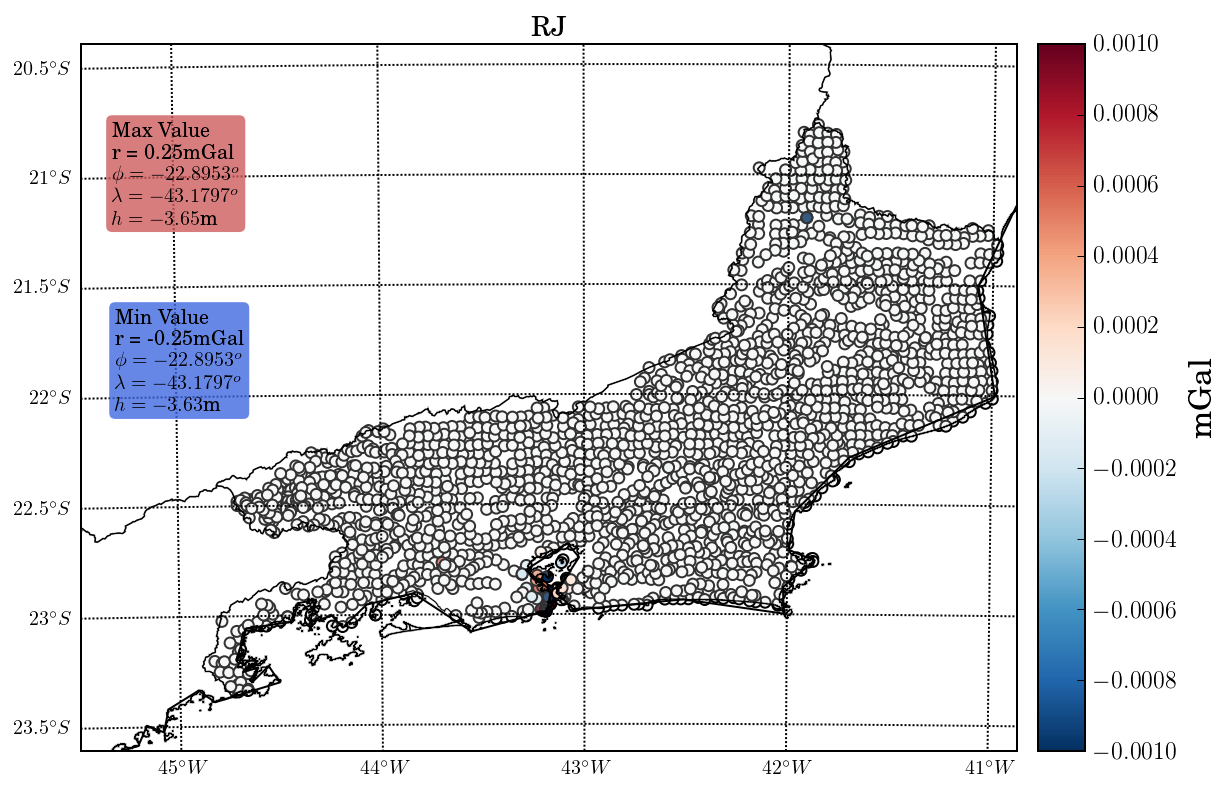

In [28]:
# Residual
point_map(lon, lat, alt, rc, uf, edges=(-45.5,-40.9,-23.6,-20.4), center=(-22.8, -21.6,-42.8), \
          drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), residual=True, lim_val=(True,1e-3), \
          fig_size=(9.,10.))#, save=name)

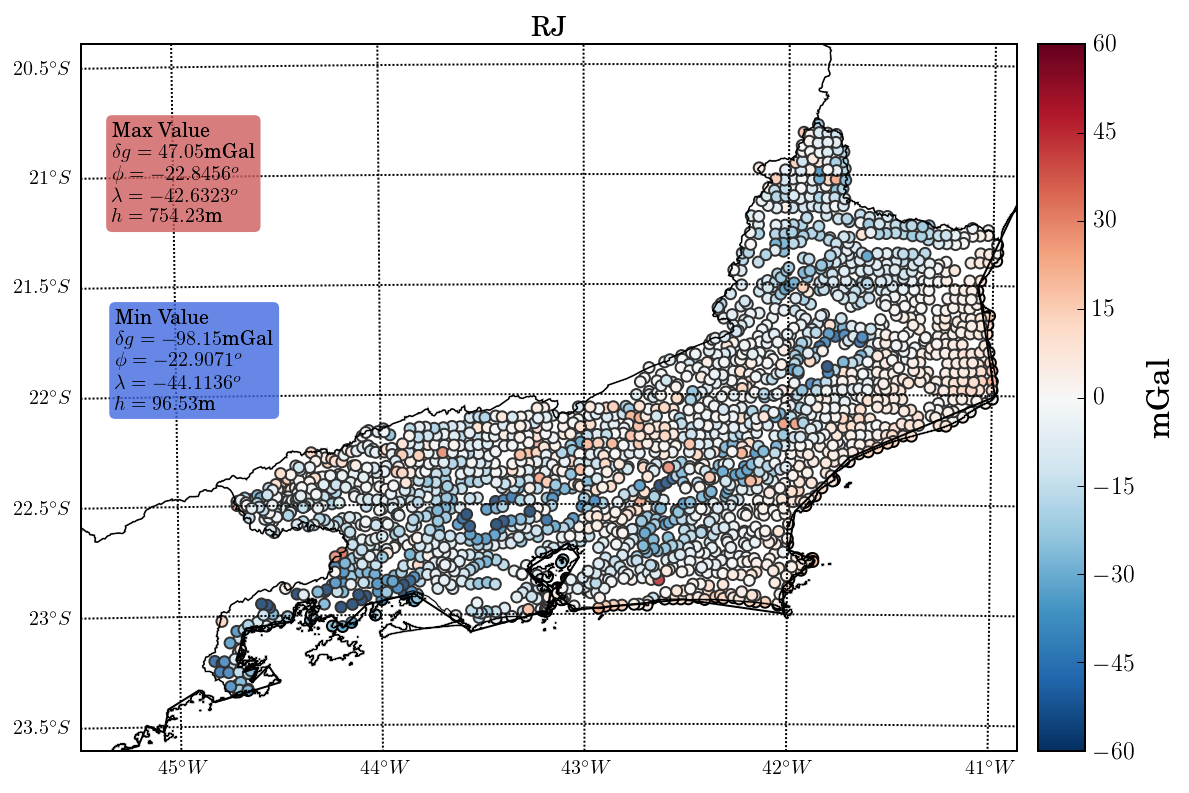

In [29]:
# Observed data
point_map(lon, lat, alt, disturb, uf, edges=(-45.5,-40.9,-23.6,-20.4), center=(-22.8, -21.6,-42.8), \
          drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), lim_val=(True,60), \
          fig_size=(9.,10.))#, save=name)

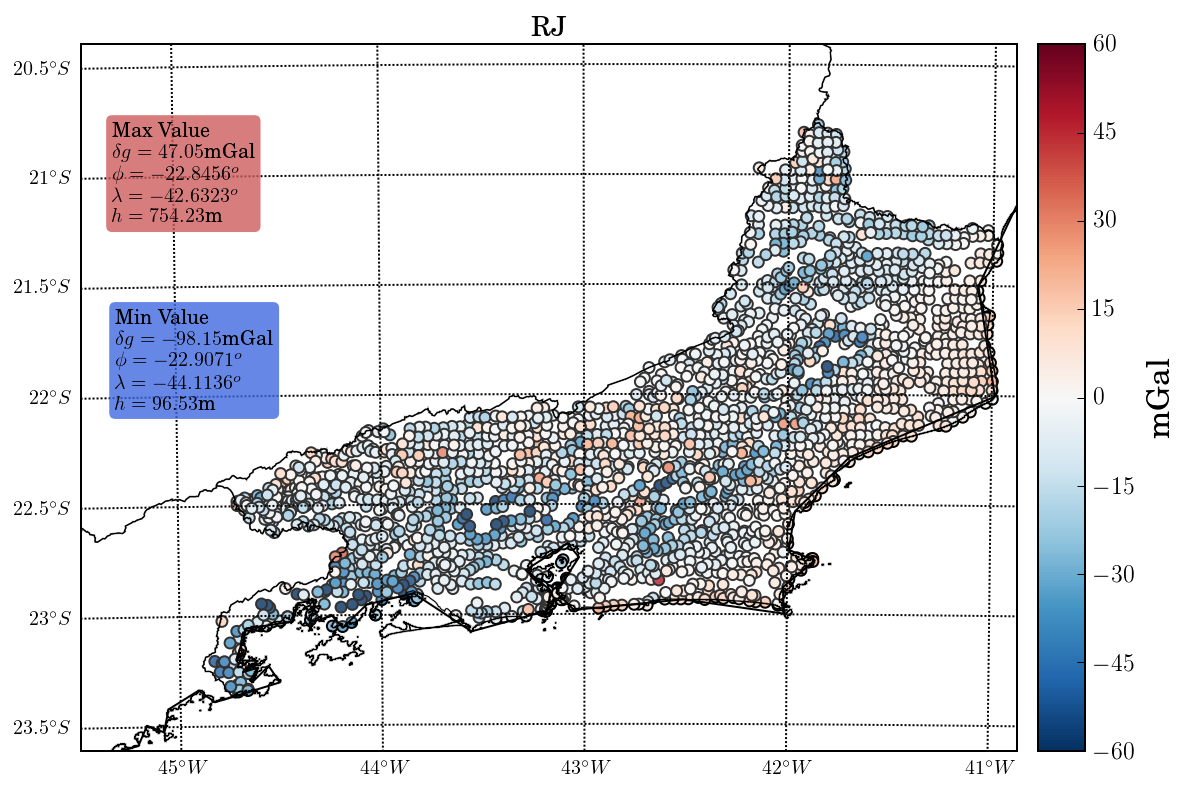

In [30]:
# Predicted data
point_map(lon, lat, alt, np.dot(Acc_l, p_L2), uf, edges=(-45.5,-40.9,-23.6,-20.4), \
          center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
          lim_val=(True,60), fig_size=(9.,10.))#, save=name)

In [31]:
ind_ = np.where(np.abs(rc) >= 1e-4)[0]
print ind_.size, p_L2.size

68 2057


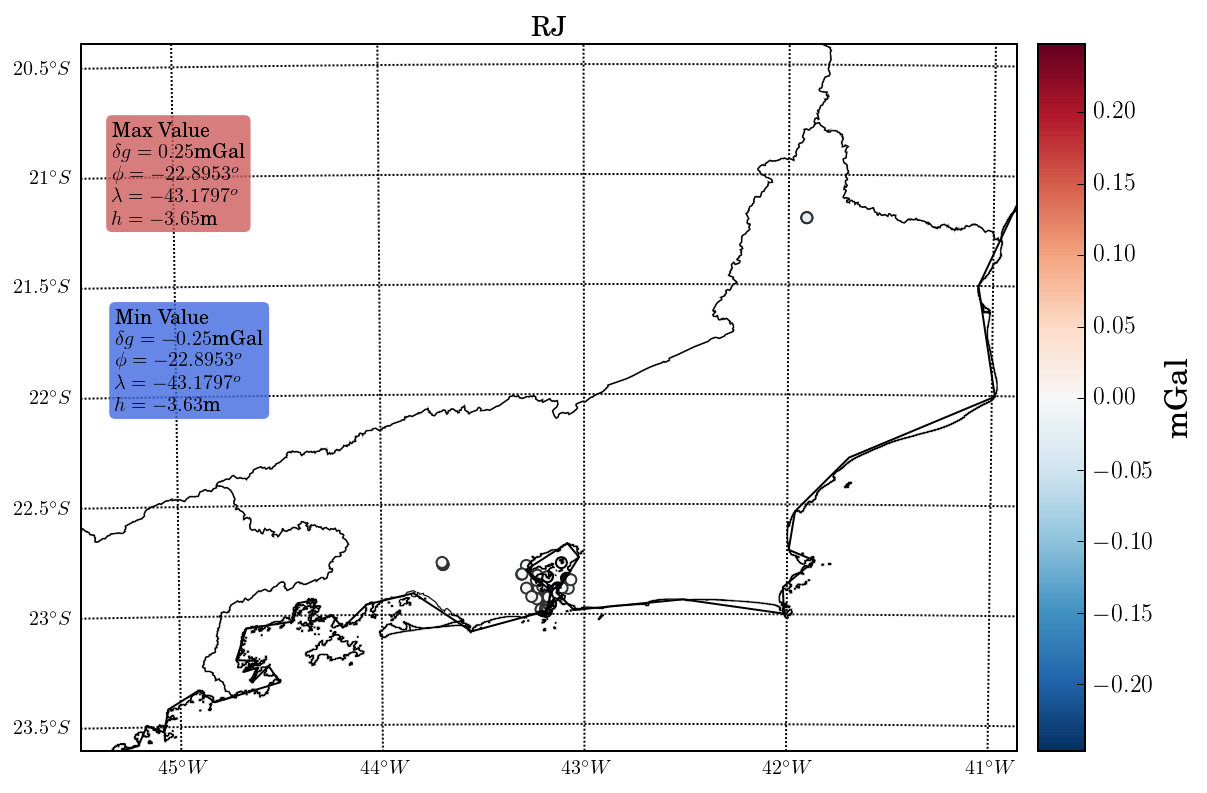

In [32]:
# Residuals
point_map(lon[ind_], lat[ind_], alt[ind_], rc[ind_], uf, edges=(-45.5,-40.9,-23.6,-20.4), \
          center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
          fig_size=(9.,10.))#, save=name)

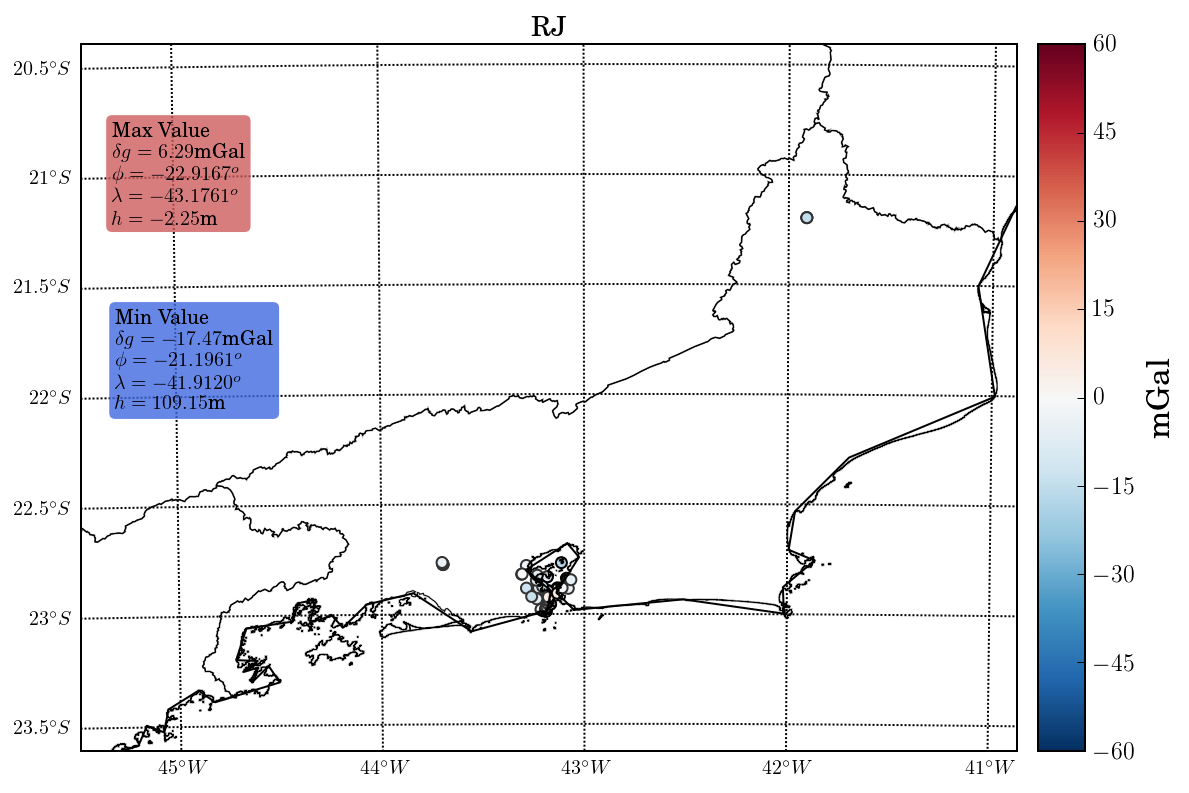

In [33]:
# Observed data
point_map(lon[ind_], lat[ind_], alt[ind_], disturb[ind_], uf, edges=(-45.5,-40.9,-23.6,-20.4), center=(-22.8, -21.6,-42.8), \
          drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), lim_val=(True,60), \
          fig_size=(9.,10.))#, save=name)

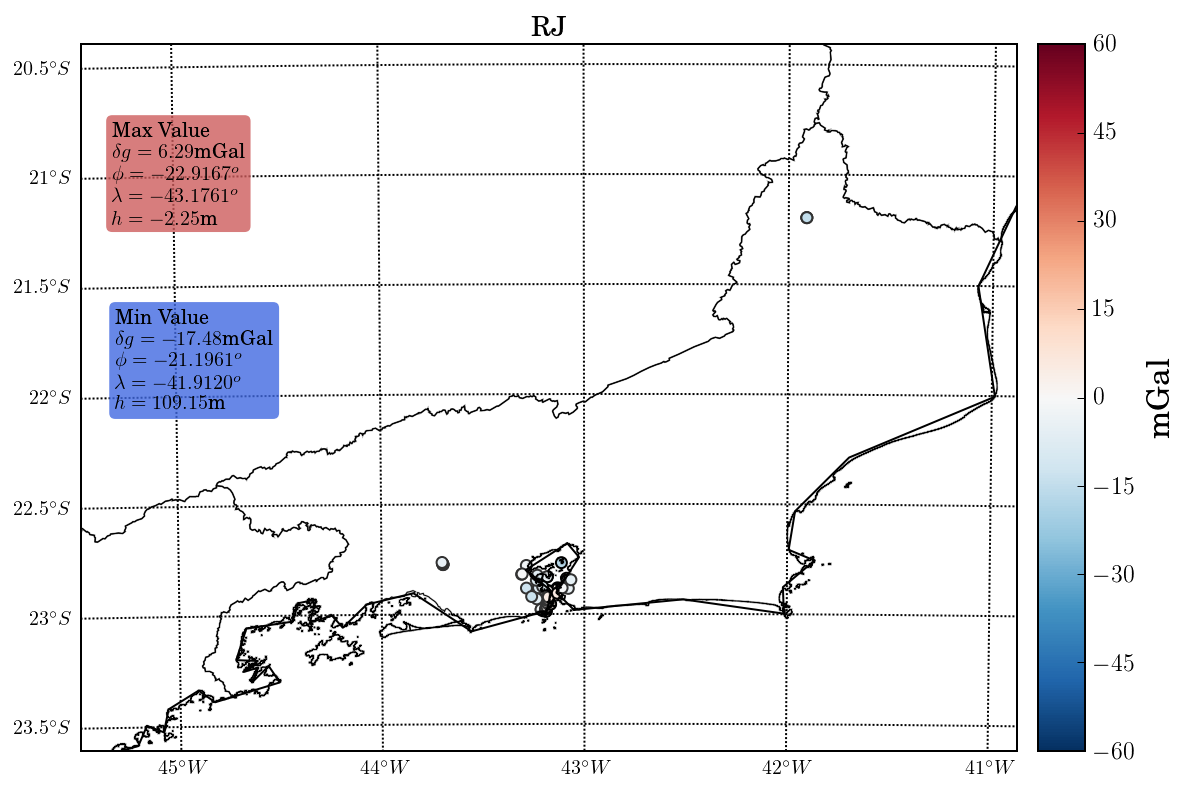

In [34]:
# Predicted data
point_map(lon[ind_], lat[ind_], alt[ind_], np.dot(Acc_l, p_L2)[ind_], uf, edges=(-45.5,-40.9,-23.6,-20.4), \
          center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
          lim_val=(True,60), fig_size=(9.,10.))#, save=name)

## Iteração 1 - A0 L1 norm

In [58]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 5000. #5000. #14200. # 20000. #800. #1000.
print hcl, type(indl), #indl

5000.0 <type 'numpy.ndarray'>


In [59]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [60]:
Rcl = R[:, indl]

In [61]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(lon, lat, np.zeros_like(lon)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print Acc_l.shape

(2057, 2057)


In [62]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [63]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size
p_L1 = L1_estim(rcl, p_L2, Acc_l, 4)

2057


In [64]:
rcl -= np.dot(Acc_l, p_L1)
# print rcl[:50]

In [65]:
indexing = np.where(rcl==np.max(rcl))[0]
index = np.where(disturb==np.max(disturb))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], disturb[indexing], np.dot(Acc_l, p_L1)[indexing]
print 'MAX FOR DISTURB'
print rcl[index], disturb[index], np.dot(Acc_l, p_L2)[index]

MAX FOR RESIDUALS
[  1.44689336e+13] [ 5.993522] [ -1.44689336e+13]
MAX FOR DISTURB
[-2.59925603] [ 47.0498974] [ 47.04989738]


In [66]:
print np.std(rcl)

594774624471.0


In [67]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

14468933611484.436

In [68]:
print rabs_max, rabs_max_l

[0.24724153904111157, 3406452.516577729] 1.44689336115e+13


In [69]:
# pc.append(p_L1)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [70]:
latc.append(latcl)
lonc.append(loncl)

In [71]:
rabs_max.append(rabs_max_l)

In [72]:
rc = rcl[:] #r1

In [73]:
print np.max(np.abs(rc))

1.44689336115e+13


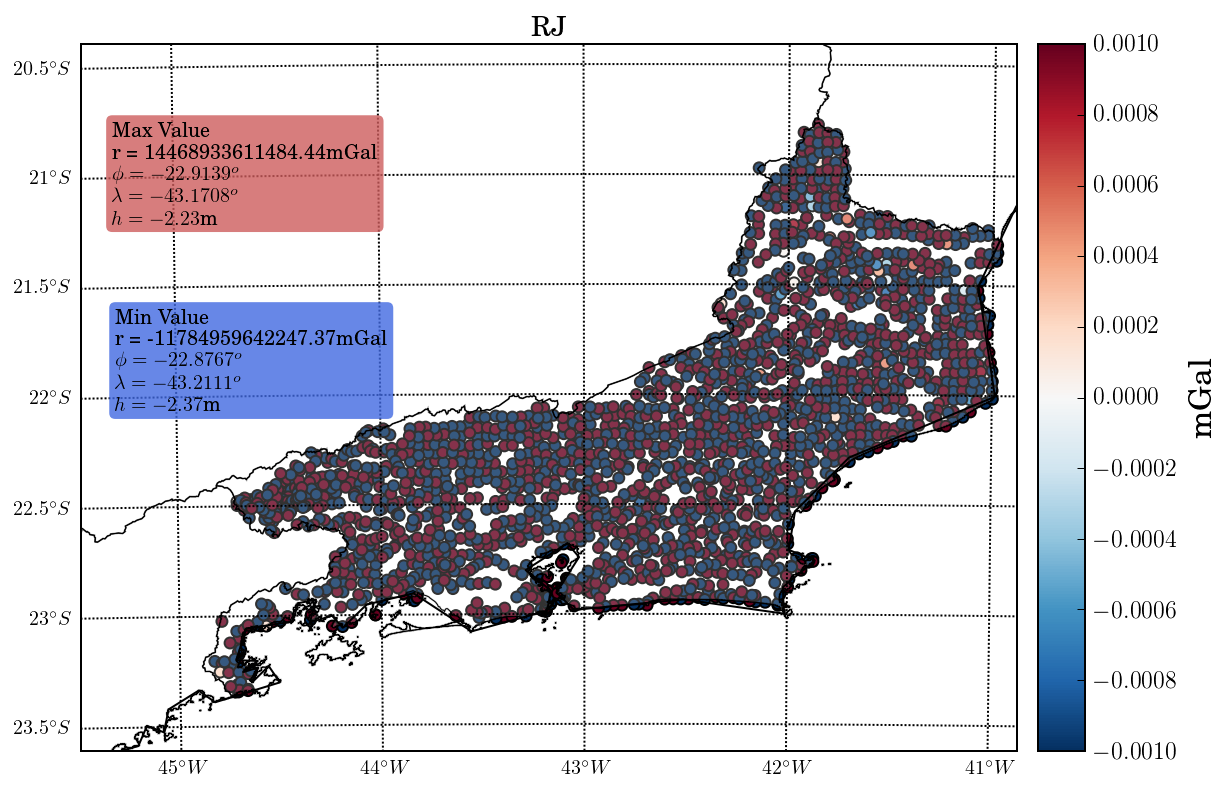

In [74]:
# Residual
point_map(lon, lat, alt, rc, uf, edges=(-45.5,-40.9,-23.6,-20.4), center=(-22.8, -21.6,-42.8), \
          drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), residual=True, lim_val=(True,1e-3), \
          fig_size=(9.,10.))#, save=name)

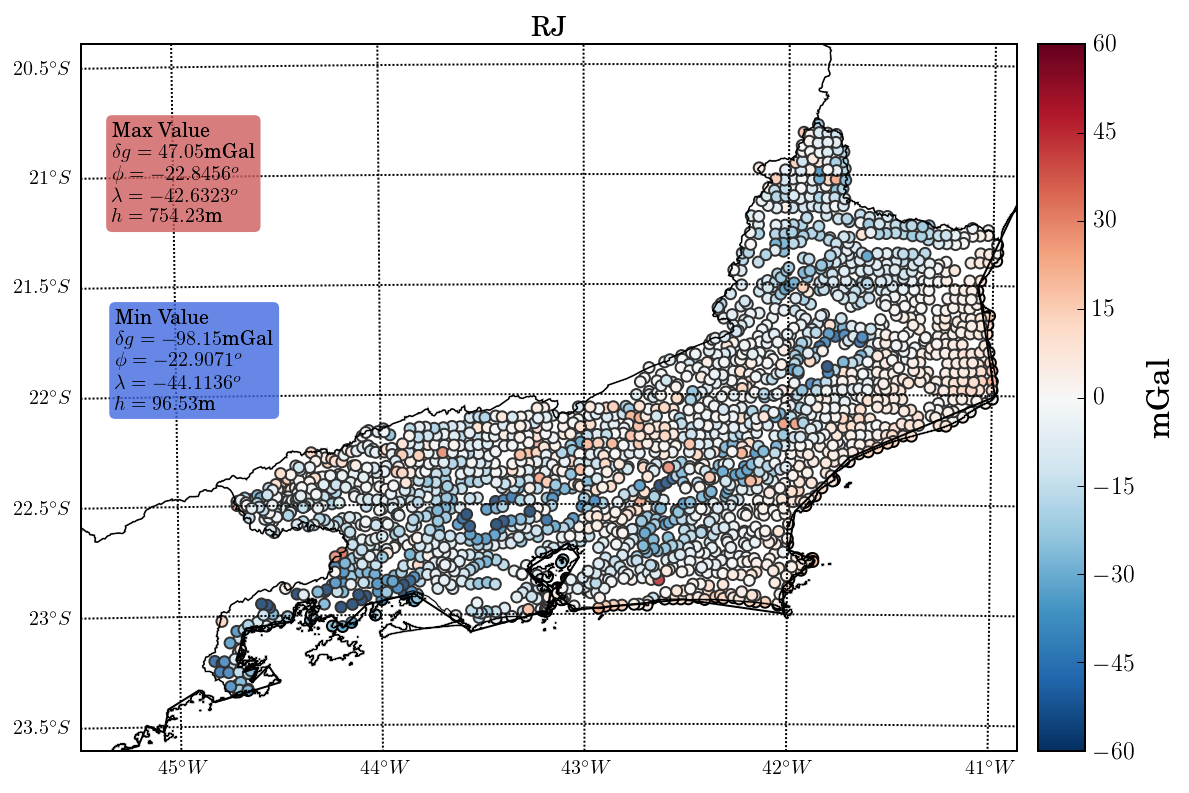

In [75]:
# Observed data
point_map(lon, lat, alt, disturb, uf, edges=(-45.5,-40.9,-23.6,-20.4), center=(-22.8, -21.6,-42.8), \
          drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), lim_val=(True,60), \
          fig_size=(9.,10.))#, save=name)

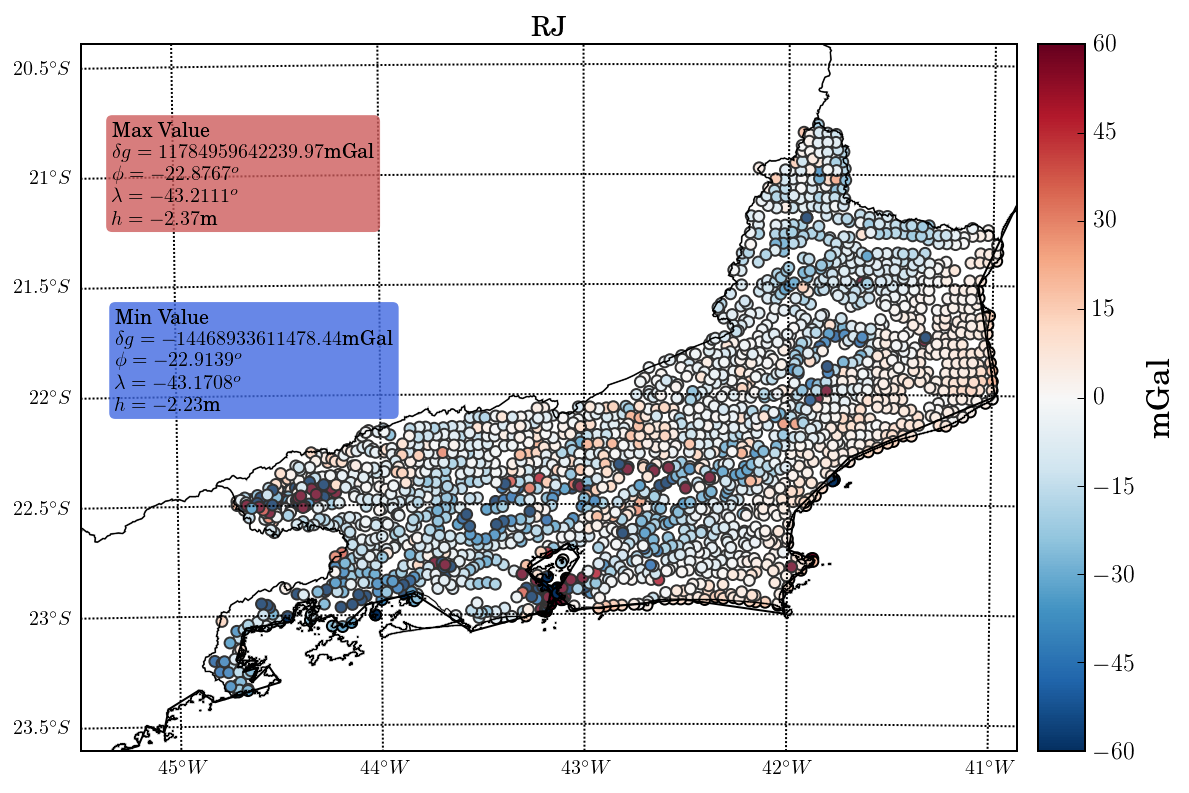

In [76]:
# Predicted data
point_map(lon, lat, alt, np.dot(Acc_l, p_L1), uf, edges=(-45.5,-40.9,-23.6,-20.4), \
          center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
          lim_val=(True,60), fig_size=(9.,10.))#, save=name)

In [77]:
ind_ = np.where(np.abs(rc) >= 1e-4)[0]
print ind_.size, p_L2.size

2055 2057


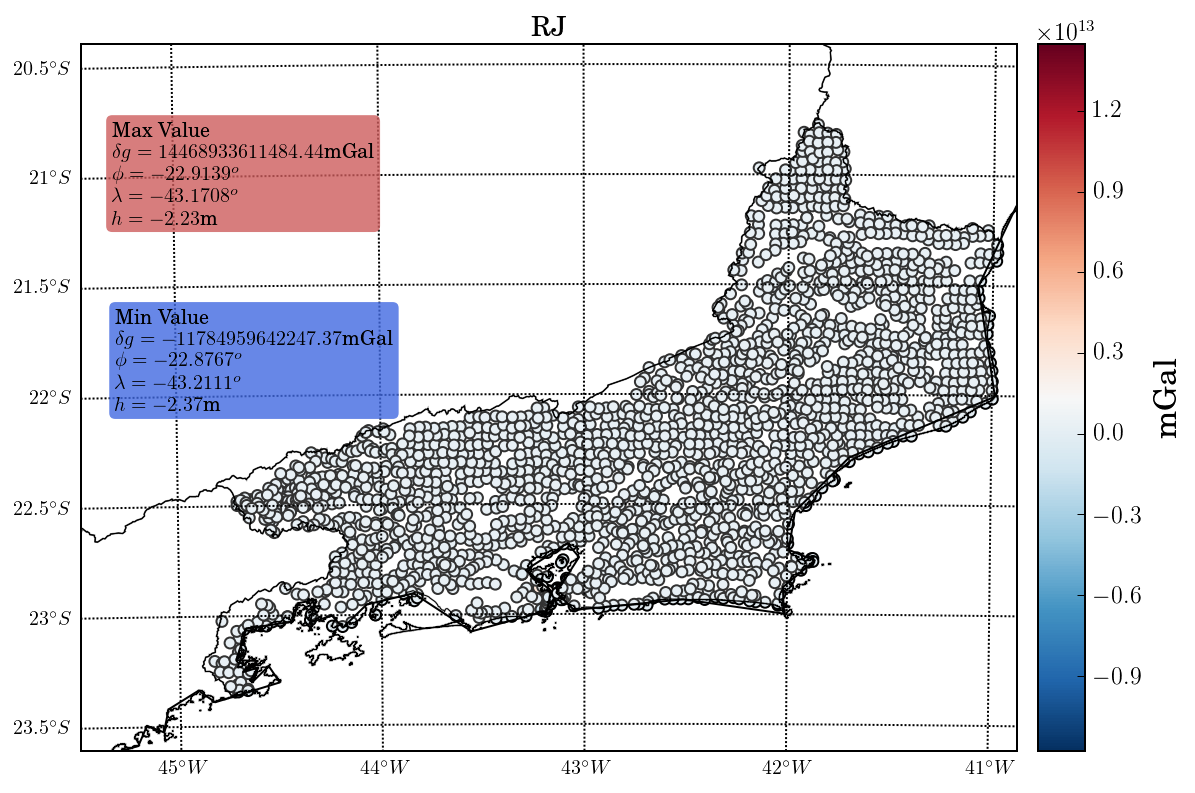

In [78]:
# Residuals
point_map(lon[ind_], lat[ind_], alt[ind_], rc[ind_], uf, edges=(-45.5,-40.9,-23.6,-20.4), \
          center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
          fig_size=(9.,10.))#, save=name)

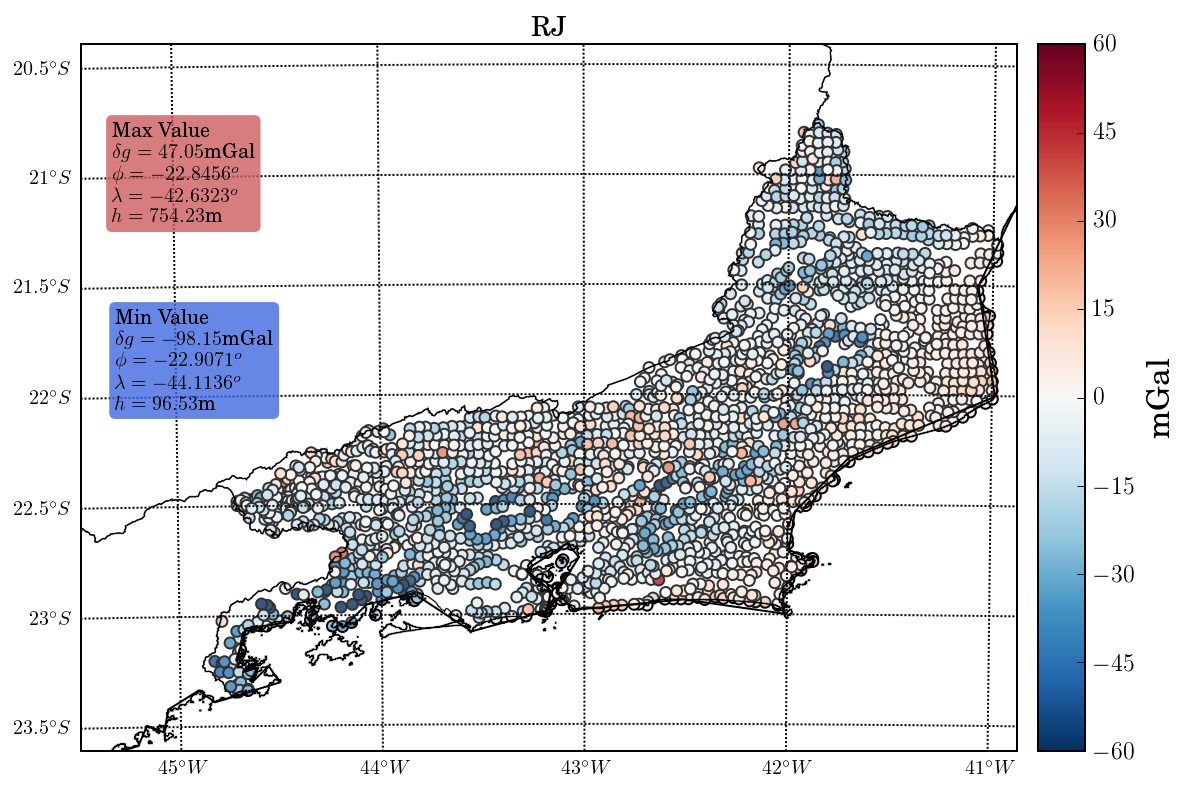

In [79]:
# Observed data
point_map(lon[ind_], lat[ind_], alt[ind_], disturb[ind_], uf, edges=(-45.5,-40.9,-23.6,-20.4), center=(-22.8, -21.6,-42.8), \
          drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), lim_val=(True,60), \
          fig_size=(9.,10.))#, save=name)

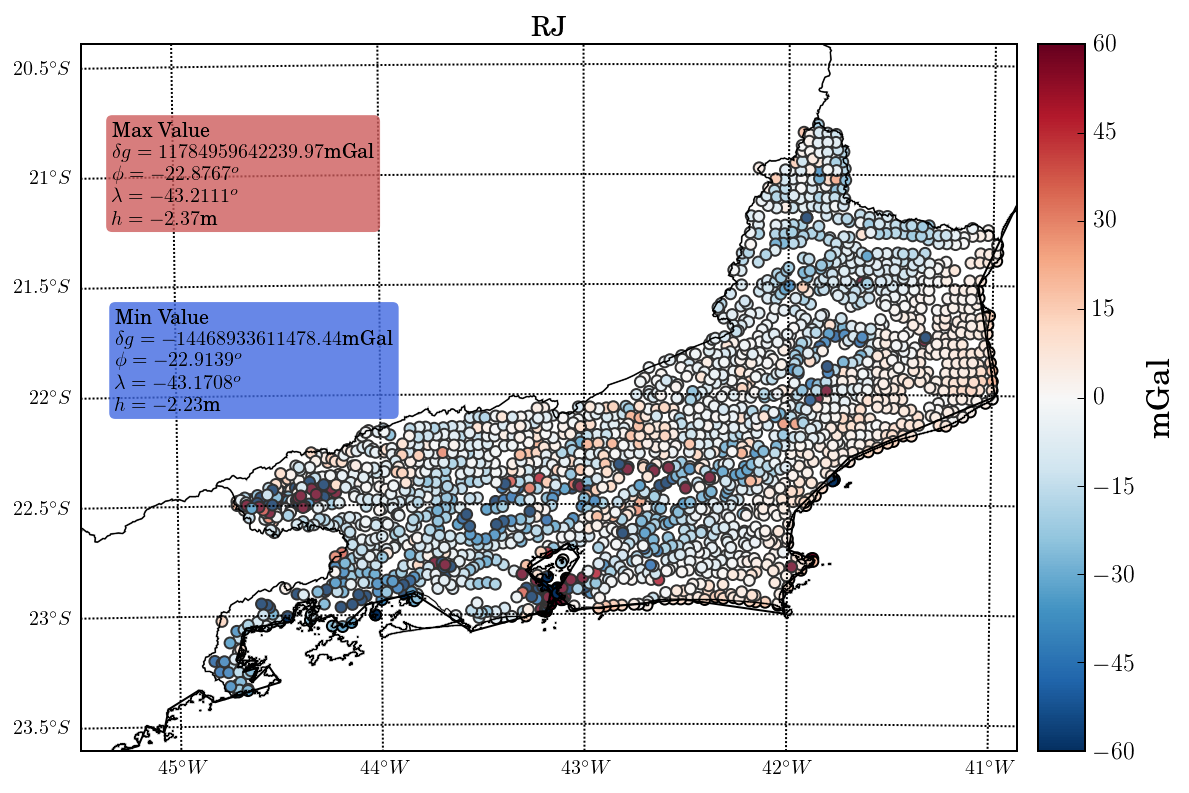

In [80]:
# Predicted data
point_map(lon[ind_], lat[ind_], alt[ind_], np.dot(Acc_l, p_L1)[ind_], uf, edges=(-45.5,-40.9,-23.6,-20.4), \
          center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
          lim_val=(True,60), fig_size=(9.,10.))#, save=name)

#### Second layer

In [ ]:
indl = np.copy(ind_)
hcl = 2000 #14200. # 20000. #800. #1000.
print hcl, type(indl), #indl

In [ ]:
data = rc[indl]
rcl = np.copy(data)
print np.max(rcl)
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]
print latcl.size

In [ ]:
Rcl = R[:, ind_]

In [ ]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(loncl, latcl, np.zeros_like(loncl)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print Acc_l.shape

In [ ]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [ ]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 1)
# print p_L1.size

In [ ]:
rcl -= np.dot(Acc_l, p_L2)
print rcl.size

In [ ]:
indexing = np.where(rcl==np.max(rcl))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], data[indexing], np.dot(Acc_l, p_L2)[indexing]

In [ ]:
print np.std(rcl)

In [ ]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

In [ ]:
print rabs_max, rabs_max_l

In [ ]:
pc.append(p_L1)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [ ]:
latc.append(latcl)
lonc.append(loncl)

In [ ]:
rabs_max.append(rabs_max_l)

In [ ]:
print indl.size

In [ ]:
# rc = rcl[:] #r1
rc[indl] = rcl #r1
print rc.size

In [ ]:
print np.max(np.abs(rc))

In [ ]:
# Residual
point_map(lon, lat, alt, rc, uf, edges=(-45.5,-40.9,-23.6,-20.4), center=(-22.8, -21.6,-42.8), \
          drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), residual=True, lim_val=(True,1e-3), \
          fig_size=(9.,10.))#, save=name)

In [ ]:
# Observed data
point_map(lon, lat, alt, disturb, uf, edges=(-45.5,-40.9,-23.6,-20.4), \
          center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
          lim_val=(True,60), fig_size=(9.,10.))#, save=name)

In [ ]:
# Predicted data
# point_map(lon, lat, alt, np.dot(Acc_l, p_L2), uf, edges=(-45.5,-40.9,-23.6,-20.4), \
#           center=(-22.8, -21.6,-42.8), drawlines=(1.,0.5), sign=(-45.3,-45.3,-21.2,-22.05), \
#           lim_val=(True,60), fig_size=(9.,10.))#, save=name)

In [ ]:
ind_ = np.where(np.abs(rc) >= 1e-5)[0]
print ind_.size, p_L2.size

In [ ]:
lat_multi = np.concatenate(latc)
lon_multi = np.concatenate(lonc)

height_multi = []
for lonci, hci, in zip(lonc, hc):
    height_multi.append(np.zeros_like(lonci) - hci)
height_multi = np.concatenate(height_multi)

In [ ]:
x_multi, y_multi, z_multi = coord.geodetic2cartesian(height_multi, lat_multi, lon_multi, a, b)
lay = eqlayer.build_layer(x_multi, y_multi, z_multi)

In [ ]:
p_multi = np.concatenate(pc)
print len(p_multi), p_multi